# Behaviour Driving

The goal of this project is to teach a virtual vehicle to drive using only the driving data that we have collected in a simulator. This idea is most recently based on a paper by NVIDIA called [End To End Driving For Self-Driving Cars](https://arxiv.org/abs/1604.07316).

Useful Resources:
* [Steering Ratio](https://en.wikipedia.org/wiki/Steering_ratio)

## Loading The Dataset

In [ ]:
# Visualizations will be shown in the notebook.
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2 

In [652]:
path = '../datasets/behavioural_driving/Dataset_2'
standard_path = '../datasets/behavioural_driving/Dataset_2'
recovery_path = '../datasets/behavioural_driving/Recovery_Driving'
udacity_path = "../datasets/behavioural_driving/Udacity/data"
track2_path = '../datasets/behavioural_driving/Track_2'
img_path = path + '/IMG'
models_path = "./models" 

In [653]:
def load_csv(file_path, col_names, remove_header=False):
    csv = pd.read_csv(file_path, header=None, names=col_names)
    if remove_header:
        csv = csv[1:]
    
    return csv 

In [654]:
# Define our column headers
col_header_names = ["Center", "Left", "Right", "Steering Angle", "Throttle", "Brake","Speed"] 

In [655]:
# Let's load our standard driving dataset, where we drive in both directions
standard_csv = load_csv(standard_path + "/driving_log.csv", col_header_names)
standard_csv["Steering Angle"] = standard_csv["Steering Angle"].astype(float) 
print("Standard dataset has {0} rows".format(len(standard_csv))) 

Standard dataset has 12979 rows


In [656]:
# Let's load the data set of driving in recovery mode (aka virtual drink driving dataset)
recovery_csv = load_csv(recovery_path + "/driving_log.csv", col_header_names)
recovery_csv["Steering Angle"] = recovery_csv["Steering Angle"].astype(float) 
print("Recovery dataset has {0} rows".format(len(recovery_csv)))

Recovery dataset has 3546 rows


In [657]:
# Let's load dataset from track 2
track2_csv = load_csv(track2_path + "/driving_log.csv", col_header_names)
track2_csv["Steering Angle"] = track2_csv["Steering Angle"].astype(float) 
print("Track 2 dataset has {0} rows".format(len(track2_csv)))

Track 2 dataset has 6395 rows


In [658]:
# Finally let's load the udacity dataset
udacity_csv = load_csv(udacity_path + "/driving_log.csv", col_header_names, remove_header=True)
udacity_csv["Steering Angle"] = udacity_csv["Steering Angle"].astype(float) 
print("Standard dataset has {0} rows".format(len(udacity_csv)))

Standard dataset has 8036 rows


## Investigation distribution of stearing angles

Let's investigate the distribution of our steering angle data.

In [659]:
def get_steering_angles(data, st_column, st_calibrations, filtering_f=None):
    """
    Returns the steering angles for images referenced by the dataframe
    The caller must pass the name of the colum containing the steering angle 
    along with the appropriate steering angle corrections to apply
    """
    cols = len(st_calibrations)
    print("CALIBRATIONS={0}, ROWS={1}".format(cols, data.shape[0]))
    angles = np.zeros(data.shape[0] * cols, dtype=np.float32)
    
    i = 0
    for indx, row in data.iterrows():        
        st_angle = row[st_column]
        for (j,st_calib) in enumerate(st_calibrations):  
            angles[i * cols + j] = st_angle + st_calib
        i += 1
    
    # Let's not forget to ALWAYS clip our angles within the [-1,1] range
    return np.clip(angles, -1, 1)

In [661]:
st_angle_names = ["Center", "Left", "Right"]
st_angle_calibrations = [0, 0.25, -0.25]

In [662]:
standard_st_angles_without_calibrations = get_steering_angles(standard_csv, "Steering Angle", [0])
recovery_st_angles_without_calibrations = get_steering_angles(recovery_csv, "Steering Angle", [0])
track2_st_angles_without_calibrations = get_steering_angles(track2_csv, "Steering Angle", [0])
udacity_st_angles_without_calibrations = get_steering_angles(udacity_csv, "Steering Angle", [0])

CALIBRATIONS=1, ROWS=12979
CALIBRATIONS=1, ROWS=3546
CALIBRATIONS=1, ROWS=6395
CALIBRATIONS=1, ROWS=8036


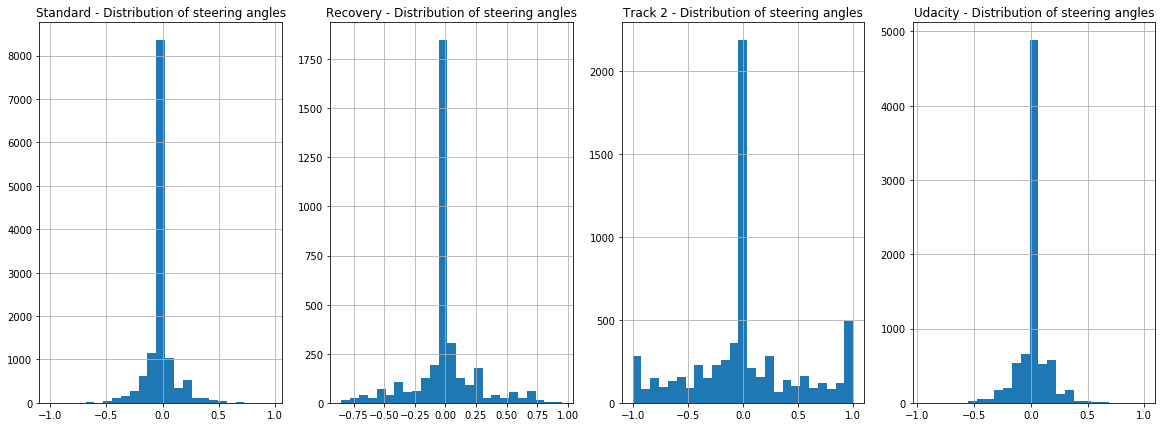

In [663]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7))

ax[0].grid(True)
ax[0].set(title="Standard - Distribution of steering angles")
count, bins, _ = ax[0].hist(standard_st_angles_without_calibrations, bins=25,histtype='bar' )

ax[1].grid(True)
ax[1].set(title="Recovery - Distribution of steering angles")
count, bins, _ = ax[1].hist(recovery_st_angles_without_calibrations, bins=25,histtype='bar' )

ax[2].grid(True)
ax[2].set(title="Track 2 - Distribution of steering angles")
count, bins, _ = ax[2].hist(track2_st_angles_without_calibrations, bins=25,histtype='bar' )

ax[3].grid(True)
ax[3].set(title="Udacity - Distribution of steering angles")
count, bins, _ = ax[3].hist(udacity_st_angles_without_calibrations, bins=25,histtype='bar' )

For track 1, the recovery dataset shows the most variability, as expected in the steering angle data. However, all three distributions show greatly imbalanced dataset, where the neutral angle (i.e. 0) overwhelmingly dwarfes all other angles. **This means, that unless we take corrective steps, our model will be biased to driving straight.**

On the other hand, in track 2, we can observe many more sharp turn and the most variabilty in steering wheel angles. There is still a strong bias towards driving straight though, even in this case.

Let's try to merge most of these datasets, using only _standard_ dataset as the validation one.

In [664]:
frames = [recovery_csv, udacity_csv, track2_csv]
ensemble_csv = pd.concat(frames)
len(ensemble_csv)

17977

We will also use part of the *standard* data as the validation set.

In [695]:
validation_csv = standard_csv
len(validation_csv)

12979

In [665]:
ensemble_st_angles_without_calibrations = get_steering_angles(ensemble_csv, "Steering Angle", [0])

CALIBRATIONS=1, ROWS=17977


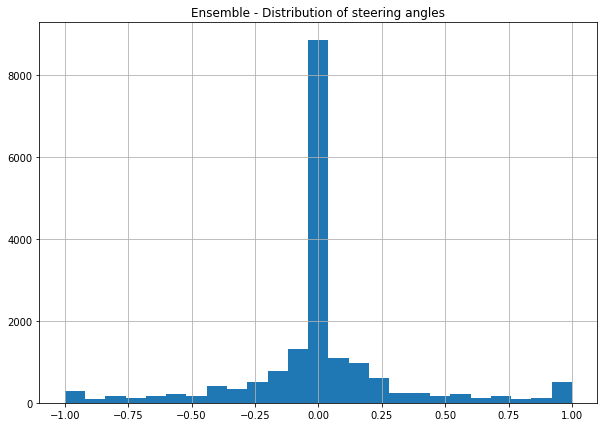

In [666]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.grid(True)
ax.set(title="Ensemble - Distribution of steering angles")
count, bins, _ = ax.hist(ensemble_st_angles_without_calibrations, bins=25, histtype='bar')

As expected, the dataset is greatly imbalanced. Neutral angles are overwhelmingly present and there is also a bias towards turning left. We will have to somehow find a way to balance this dataset.

## Load Images

We define a simple function that loads the images given the path.

In [667]:
def read_img(img_full_path, img_dir="/IMG"):
    prefix_path = udacity_path + img_dir

    if "Dataset_2" in img_full_path:
        prefix_path = standard_path + img_dir
    elif "Recovery_Driving" in img_full_path:
        prefix_path = recovery_path + img_dir
    elif "Track_2" in img_full_path:
        prefix_path = track2_path + img_dir
    
    img_path = "{0}/{1}".format(prefix_path, img_full_path.split("/")[-1])    
    img = cv2.imread(img_path)
    
    # OpenCV reads images in BGR format, we are simply converting and returning the image in RGB format
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Implementing Image Augmentation Functions

In this section we present multiple functions to modify a given image. We combine them as part of our image augmentation pipeline.

In [ ]:
def fliph_image(img):
    """
    Returns a horizontally flipped image
    """
    return cv2.flip(img, 1)

In [ ]:
def blur_image(img, f_size=5):
    """
    Applies Gaussir Blur to smoothen the image.
    This in effect performs anti-aliasing on the provided image
    """
    img = cv2.GaussianBlur(img,(f_size, f_size),0)
    img = np.clip(img, 0, 255)

    return img.astype(np.uint8) 

In [ ]:

# Read more about it here: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
def translate_image(img, st_angle, low_x_range, high_x_range, low_y_range, high_y_range, delta_st_angle_per_px):
    """
    Shifts the image right, left, up or down. 
    When performing a lateral shift, a delta proportional to the pixel shifts is added to the current steering angle 
    """
    rows, cols = (img.shape[0], img.shape[1])
    translation_x = np.random.randint(low_x_range, high_x_range) 
    translation_y = np.random.randint(low_y_range, high_y_range) 
    
    st_angle += translation_x * delta_st_angle_per_px

    translation_matrix = np.float32([[1, 0, translation_x],[0, 1, translation_y]])
    img = cv2.warpAffine(img, translation_matrix, (cols, rows))
    
    return img, st_angle 

In [589]:
def change_image_lightness(img, low, high):
    """
    Applies an offset in [low, high] interval to change the 'L' component of the supplied image in HSL format
    The returned image in converted back to RGB
    """
    # Convert to HSL (HLS in OpenCV!!)
    hls = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HLS)
    hls = hls.astype(int)    
    
    # Add an offset to light component 
    offset = np.random.randint(low, high=high)
    # Since the format is HLS and NOT HSL, it is the second component (index 1) that is modified
    #hls[:,:,1] += offset
    hls[:,:,1] = offset

    # Make sure our lightness component is in the interval [0, 255]
    np.clip(hls, 0, 255)
    
    # Convert back to uint
    hls = hls.astype(np.uint8)
    
    # Make sure we return image in RGB format
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB) 

In [ ]:
def change_image_brightness(img, low, high):
    """
    Applies an offset in [low, high] interval to change the 'V' component of the supplied image in HSV format
    The returned image in converted back to RGB
    """

    # Convert to HSV
    hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV)
    hsv = hsv.astype(int)    
    
    # Adding the offset to the v component
    offset = np.random.randint(low, high=high)
    hsv[:,:,2] += offset
    
    # Make sure our lightness component is in the interval [0, 255]
    np.clip(hsv, 0, 255)
    
    # Convert back to uint
    hsv = hsv.astype(np.uint8)
    
    # Make sure we return image in RGB format
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB) 

In [ ]:
def add_random_shadow(img, w_low=0.6, w_high=0.85):
    """
    Overlays supplied image with a random shadow poligon
    The weight range (i.e. darkness) of the shadow can be configured via the interval [w_low, w_high)
    """
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)

    
    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv2.fillPoly(mask, poly, (0, 0, 0))
    #masked_image = cv2.bitwise_and(img, mask)
    
    return cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

In [ ]:
def shift_horizon(img, h_s=0.2):
    img = img.astype(np.float32)
    
    # randomly shift horizon
    height = img.shape[0]
    width = img.shape[1]
    horizon = h_s * height / 3
    v_shift = np.random.randint(-height/8,height/8)
    pts1 = np.float32([[0, horizon],[width, horizon], [0, height], [width, height]])
    pts2 = np.float32([[0, horizon + v_shift],[width, horizon + v_shift], [0, height], [width, height]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    img = cv2.warpPerspective(img, M,(width, height), borderMode=cv2.BORDER_REPLICATE)
    
    return img.astype(np.uint8)

In [ ]:
def change_gamma(img, gamma=0.5):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    img = img.astype(np.float32) 
    img /= 255.0
    
    #img[:,:100,:] = img[:,:100,:] ** invGamma
    #img *= 255
    #img = img.astype(np.uint8)
    img = cv2.bitwise_and(img * 255, img * 255, mask=img[:,:100,:] ** invGamma)
    return img
    
    #table = np.array([((i / 255.0) ** invGamma) * 255
    #for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(img, table)

In [644]:
def change_image_brightness_rgb(img, s_low=0.2, s_high=0.75):
    """
    Changes the image brightness by multiplying all RGB values by the same scalacar in [s_low, s_high).
    Returns the brightness adjusted image in RGB format.
    """
    img = img.astype(np.float32)
    s = np.random.uniform(s_low, s_high)
    img[:,:,:] *= s
    np.clip(img, 0, 255)
    return  img.astype(np.uint8)

In [668]:
def augment_image(img, st_angle, p=1.0):
    """
    Augment a given image, by applying a series of transformations, with a probability p.
    The steering angle may also be modified.
    Returns the tuple (augmented_image, new_steering_angle)
    """
    aug_img = img
    
    #if np.random.random_sample() <= 1.0:
        # Reduce aliasing via blurring
        #aug_img = blur_image(aug_img)
   
    if np.random.random_sample() <= 0.5: 
        # Horizontally flip image
        aug_img = fliph_image(aug_img)
        st_angle = -st_angle
     
    if np.random.random_sample() <= 0.5:
        # Change image brightness or lightness
        #low = -np.random.randint(25, high=100)
        #high = np.random.randint(25, high=100)
        #if np.random.random_sample() <= 0.5:
            # Try changes in lightness
            #aug_img = change_image_lightness(aug_img, low, high)
        #else:
            # Try changes in brightness
            #aug_img = change_image_brightness(aug_img, low, high)
        # TODO Maybe use change_brightness_rgb function instead??
        aug_img = change_image_brightness_rgb(aug_img)
    
    if np.random.random_sample() <= 0.5: 
        aug_img = add_random_shadow(aug_img, w_low=0.45)
            
    if np.random.random_sample() <= 0.5:
        # Shift the image left/right, up/down and modify the steering angle accordingly
        aug_img, st_angle = translate_image(aug_img, st_angle, -60, 61, -20, 21, 0.35/100.0)
    
    # TODO Try adding slight rotations
        
    return aug_img, st_angle

## Keras Image Generator

As we want to artificially increase our dataset, as well as the variability of our images, *on the fly*, we create a Keras generator to do so. At every batch it returns a set of augmented images.

In [694]:
def generate_images(df, target_dimensions, img_types, st_column, st_angle_calibrations, batch_size=100, shuffle=True, 
                    data_aug_pct=0.8, aug_likelihood=0.5, st_angle_threshold=0.05, neutral_drop_pct=0.25):
    """
    Generates images whose paths and steering angle are stored in supplied dataframe object df
    Returns the tuple (batch,steering_angles)
    """
    # e.g. 160x320x3 for target_dimensions
    batch = np.zeros((batch_size, target_dimensions[0],  target_dimensions[1],  target_dimensions[2]), dtype=np.float32)
    steering_angles = np.zeros(batch_size)
    df_len = len(df)
    
    while True:
        k = 0
        while k < batch_size:            
            idx = np.random.randint(0, df_len)       

            for img_t, st_calib in zip(img_types, st_angle_calibrations):
                if k >= batch_size:
                    break
                                
                row = df.iloc[idx]
                st_angle = row[st_column]            
                
                # Drop neutral-ish steering angle images with some probability
                if abs(st_angle) < st_angle_threshold and np.random.random_sample() <= neutral_drop_pct :
                    continue
                    
                st_angle += st_calib                                                                
                img_type_path = row[img_t]  
                img = read_img(img_type_path)                
                
                # Resize image
                    
                img, st_angle = augment_image(img, st_angle, p=aug_likelihood) if np.random.random_sample() <= data_aug_pct else (img, st_angle)
                batch[k] = img
                steering_angles[k] = st_angle
                k += 1
            
        yield batch, np.clip(steering_angles, -1, 1)            

### Viewing Some Of Our Augmented Images

We view the results of the augmentations in this section.

In [ ]:
def show_images(imgs, labels, cols=5, fig_size=(15, 5)):
    rows = len(imgs) // cols
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    for r in range(rows):
        for c in range(cols):
            ax = axes[r,c]
            img = imgs[cols * r + c]
            lb = labels[cols * r + c]
            ax.imshow(img.astype(np.uint8))
            ax.axis('on')
            ax.set_aspect('equal')
            ax.set(title=lb)
    fig.tight_layout()
    plt.show()
    

In [670]:
b_divider = 20
# Multiplying by 3 since we have center, left and right images per row
b_size = len(ensemble_csv)  * 3 // b_divider
b_size

2696

In [696]:
gen = generate_images(ensemble_csv, (160, 320, 3), st_angle_names, "Steering Angle", st_angle_calibrations,  batch_size=b_size)

# Don't augment validation data at all
gen_validation = generate_images(validation_csv, (160, 320, 3), st_angle_names, "Steering Angle", st_angle_calibrations,  batch_size=b_size, data_aug_pct=0.0)


In [693]:
b, s = next(gen)

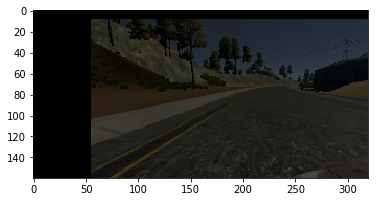

In [673]:
b0 = b[7]
b0_l = change_image_brightness_rgb(b0, s_low=0.2, s_high=0.75)
plt.imshow(b0_l)

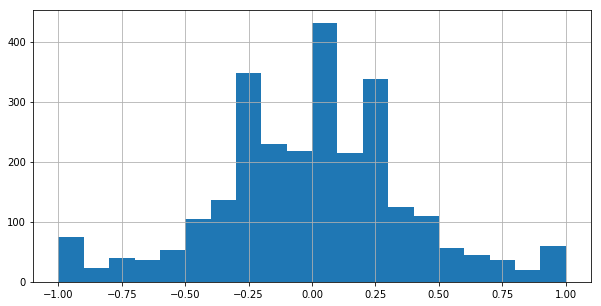

In [674]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.grid(True)
count, bins, _ = ax.hist(s, bins=20,histtype='bar' )

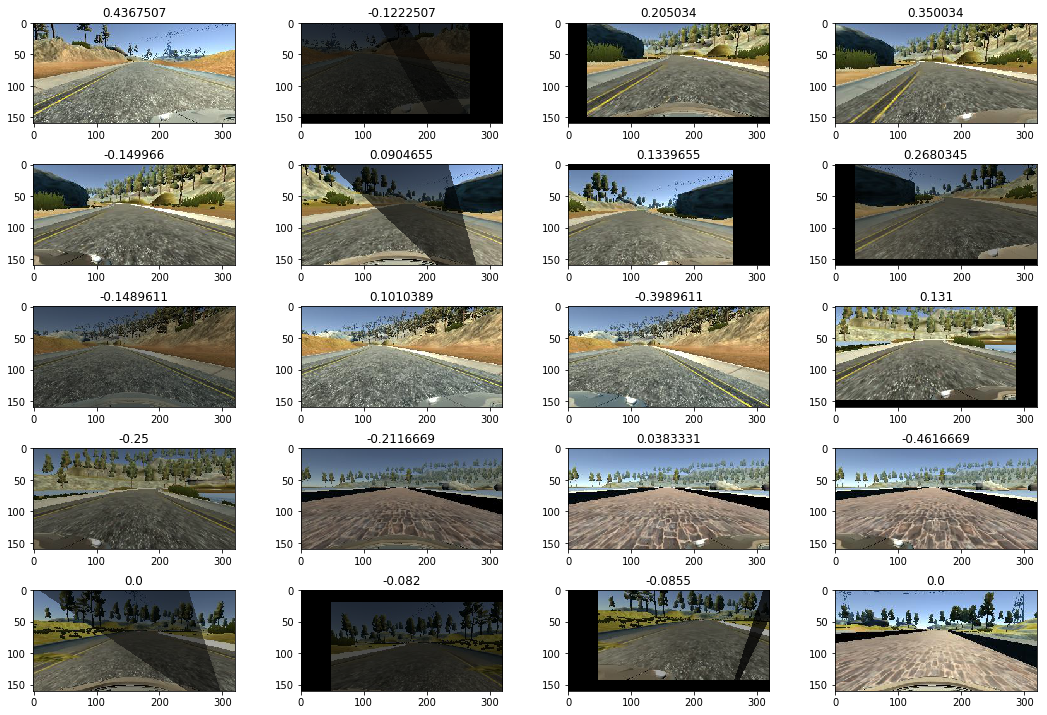

In [675]:
show_images(b[100:120], s[100:120], cols=4, fig_size=(15, 10))

We can observe that the images are well augmented. This should hopefully help our model generalise

## Build A Neural Net To Predict Steering Angles

We are using Keras, which in turn delegates to Tensorflow under the hood. Let's import all the functions we need.

In [ ]:
# Initial Setup for Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K 

In [ ]:
# Let's also define the input shape
in_shape = (160, 320, 3)

### Simple Model

In this section we create a simple model to predict steering angles. There are no convolutions in this architecture, and since this is a pure _regression_ problem, and not a _classification_ one, we will be using the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) as the activation function in the last layer.

In [ ]:
def simple_model():
    model = Sequential()
    model.add(Flatten(input_shape=in_shape))
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = "adam", metrics=['accuracy'])
    return model

In [ ]:
m = simple_model()
history = m.fit(X_train, y_train, nb_epoch=50, validation_split=0.2, shuffle=True, verbose=0)

In [ ]:
# TODO PRINT ERROR IN FUTURE
print(history.history['val_acc'])

In [ ]:
# TODO PRINT ERROR IN FUTURE
print(history.history['val_loss'])

In [ ]:
m.save("{0}/simple_model.h5".format(models_path))

In [ ]:
def plot_results(hist, metrics, xlb, ylb, title, leg, fsize = (10, 5)):
    fig, ax = plt.subplots(1, 1, figsize=fsize)
    for m in metrics:        
        ax.plot(hist.history[m])
    
    ax.set(xlabel=xlb, ylabel=ylb, title=title)
    ax.set_yscale('log')

    ax.legend(leg, loc='upper left')
    plt.show()

In [ ]:
plot_results(history, ["acc", "val_acc"], "epoch", "accuracy", "Accuracy vs Epochs", ["Training", "Validation"])

In [ ]:
plot_results(history, ["loss", "val_loss"], "epoch", "loss", "Loss vs Epochs", ["Training", "Validation"])

We are not getting a stable network at all. The loss is erratic as well as the accuracy, and we are barely reaching 0.1% on the training set. We will explore next the architecture employed by the team from the NVIDIA paper.

## NVIDIA Model

### Pre-processing steps

In [ ]:
mean_channels = [mean_r, mean_g, mean_b]
print("Mean for channels is {0}".format(mean_channels))

In [ ]:
def crop(imgs):
    return imgs[:,crop_y_start:,:,:]

In [677]:
def resize(img):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(img, [66, 200])

In [ ]:
def resize_sq(img):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(img, [66, 66])

In [ ]:
def normalize_mean_channels(img):
    return img - [136.19009391165321, 142.25525395939627, 133.84246425028346]

In [678]:
def nvidia_model():
    model = Sequential()
    # Cropping image
    model.add(Lambda(lambda imgs: imgs[:,80:,:,:], input_shape=(160, 320, 3)))
    # Normalise the image - center the mean at 0
    model.add(Lambda(lambda imgs: (imgs/255.0)))
    model.add(Lambda(resize))
    
    # TODO use Keras.Cropping instead of a lambda layer

    # We have a series of 3 5x5 convolutional layers with a stride of 2x2
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.5))

    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.5))

    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))    
    model.add(BatchNormalization())
    #model.add(Dropout(0.5))

    
    # This is then followed by 2 3x3 convolutional layers with a 1x1 stride
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu')) 
    model.add(BatchNormalization())
    #model.add(Dropout(0.5))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu')) 
    model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    
    # Flattening the output of last convolutional layer before entering fully connected phase
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(1164, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(10, activation='relu'))
    model.add(BatchNormalization())
    
    # Output layer
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = Adam(lr = 0.001))
    return model 

In [ ]:
def conv_model_2():
    from keras.backend import tf as ktf
    
    model = Sequential()
    # Cropping image
    model.add(Lambda(lambda imgs: imgs[:,80:140,:,:], input_shape=(160, 320, 3)))
    # Normalise the image - center the mean at 0
    model.add(Lambda(lambda imgs: (imgs/255.0) - 0.5))
    
    model.add(Lambda(resize_sq))
    #model.add(Lambda(lambda imgs: ktf.image.resize_images(imgs, [66, 66])))
    
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    
    # Flattening the output of last convolutional layer before entering fully connected phase
    model.add(Flatten())
    
    # Fully connected layers    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
        
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    
    # Output layer
    model.add(Dense(1))
    
    model.compile(loss = "MSE", optimizer = Adam(lr = 0.001))
    return model 

In [697]:
m = nvidia_model()

In [ ]:
m2 = conv_model_2()

In [ ]:
m2.summary()

In [ ]:
m.summary()

In [699]:
gen_train = generate_images(ensemble_csv, in_shape, st_angle_names, "Steering Angle", st_angle_calibrations,  batch_size=b_size)

In [700]:
# Take 20% of the data
gen_val = generate_images(validation_csv, in_shape, st_angle_names, "Steering Angle", st_angle_calibrations,  batch_size=(b_size * b_divider) // 5, data_aug_pct=0.0)
x_val, y_val = next(gen_val)

In [ ]:
m2.fit_generator(gen_train, samples_per_epoch=b_size * b_divider, nb_epoch=10, verbose=1)

In [ ]:
m2.save("{0}/ed_vgg.h5".format(models_path))

In [701]:
m.fit_generator(gen, validation_data=(x_val, y_val), samples_per_epoch=b_size * b_divider, nb_epoch=2, verbose=1)

Epoch 1/2
53920/53920 [==============================] - 127s - loss: 0.4923 - val_loss: 0.0588
Epoch 2/2
53920/53920 [==============================] - 122s - loss: 0.1294 - val_loss: 0.0789


In [684]:
m.save("{0}/nvida_model_3.h5".format(models_path))

In [ ]:
from keras.models import load_model,model_from_json

In [ ]:
#m2 = load_model("{0}/nivida_model.h5".format(models_path), custom_objects={"tf": backend.tf})
m2 = load_model("{0}/nivida_model_4.h5".format(models_path))

In [ ]:
model2 = model_from_json(m.to_json(), custom_objects={"ktf.image.resize_images": ktf.image.resize_images})